In [ ]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import rustworkx as rx
import random
import matplotlib.pyplot as plt
from src.retriever import *
from src.embedder import encode
from tqdm import tqdm
from src.network import NetworkAnalysis, get_verse_network
from src.rust_network import RustNetworkAnalysis, get_verse_rust_network
from pymilvus import connections, utility

 Load Milvus Collection

In [79]:
from src.utils import connect_and_load_milvus_collection

collection = connect_and_load_milvus_collection(encoder_model=encoder_model)

Get target text from Milvus via pymilvus query on the collection

In [82]:

from src.network_plots import get_target_verses, get_node_colors_per_centrality, plot_centrality_based_subgraph, map_numbers 

texts =  ['Bible', 'Quran', 'Torah', 'Gita', 'Analects']

text = 'Analects'

target_verses = get_target_verses(collection, [text])


Get Verse Network class, for graph analytics from networkx library, also

Get Verse network class, for optimized graph analytics with rustworkx:


In [83]:
# G = get_verse_network(collection, [text],  target_verses, similarity_threshold= 0.5)
G_rust = get_verse_rust_network(collection, [text],  target_verses, similarity_threshold= 0.5)

100%|██████████| 766/766 [00:02<00:00, 360.37it/s]


Check general properties of graphs in netowrkx and in rust number of disconnected subgraphs (components):

In [84]:
# print(G.number_of_nodes())
# print(G.number_of_edges())
# components = nx.connected_components(G)
# print(len(list(components)))

print(G_rust.num_nodes())
print(G_rust.num_edges())
components = rx.connected_components(G_rust)
print(len(list(components)))

766
3694
303


Run full Analysis:, and save results, that should give us:

* Average Degree
* Average Clustering Coefficient
* Network Density
* Average Path Length
* Average Betweenness Centrality
* Highest Degree Centrality
* Highest Betweenness Centrality
* Highest Closeness Centrality

In [85]:
# analysis = NetworkAnalysis(G)
# analysis.run()
# analysis.print_results()
# special_nodes = analysis.get_special_nodes()
# analysis.plot_metrics()

rust_analysis = RustNetworkAnalysis(G_rust)
rust_analysis.run()
rust_analysis.print_results()
rust_analysis.save_results(text)
special_nodes = rust_analysis.get_special_nodes()
# rust_analysis.plot_metrics()

Calculating average Degree
Running average clustering coefficient
Running network density
Running average path length
Running average betweenness centrality
Running average closeness centrality
Running get component length histogram
Calculating highest degree centrality
Calculating highest betweenness centrality
Calculating highest closeness centrality
{
    "Average Degree": 9.644908616187989,
    "Average Clustering Coefficient": 0.1872521640252473,
    "Network Density": 0.01260772368129149,
    "Average Path Length": 2.782588776483348,
    "Average Betweenness Centrality": 0.0008517156583538,
    "Component Length Histogram": {
        "1": 301,
        "463": 1,
        "2": 1
    },
    "Highest Degree Centrality": [
        "Shu er \u8ff0\u800c [7:31]",
        0.09934640522875816
    ],
    "Highest Betweenness Centrality": [
        "Gongye Chang \u516c\u51b6\u9577 [5:8]",
        0.02187441403020246
    ],
    "Highest Closeness Centrality": [
        "Xianjin \u5148\u9032 [1

Plot metrics and get special nodes! note that each node corresponds to a verse in the texts:

Take look at the special verses!

In [86]:
special_nodes

{'Highest Degree Centrality': ('Shu er 述而 [7:31]', 0.09934640522875816),
 'Highest Betweenness Centrality': ('Gongye Chang 公冶長 [5:8]',
  0.02187441403020246),
 'Highest Closeness Centrality': ('Xianjin 先進 [11:24]', 0.29682102628285356)}

In [87]:
degree_centrality_verse, betweenness_centrality_verse, closeness_centrality_verse = rust_analysis.get_special_verses(target_verses)


print(degree_centrality_verse)
print(betweenness_centrality_verse)
print(closeness_centrality_verse)

('Shu er 述而 [7:31]', ' The Minister of Justice in Chen asked whether the Duke of Zhao knew the rules of propriety. ')
('Gongye Chang 公冶長 [5:8]', ' Meng Wu Bo asked Confucius whether Zi Lu was a ren man. ')
('Xianjin 先進 [11:24]', ' Zi Lu (You), Zi Xi (Qiu), Zan You (Chi) and Gong Xihua (Dian) were sitting with the Master. Confucius said, "Although I am a day or so older than you fellows, forget about it for the time being. You are all always saying: \'Our talents are unrecognized.\' Suppose your abilities were fully acknowledged. What would you do then?" ')


In [88]:
betweenness_centrality_verse_index = rust_analysis.calculate_highest_betweenness_centrality_index()
closeness_centrality_verse_index  = rust_analysis.calculate_highest_closeness_centrality_index()
degree_centrality_verse_index = rust_analysis.calculate_highest_degree_centrality_index()

In [92]:
from src.network_plots import get_target_node_subgraph


closeness_centrality_subgraph, nodes_to_include, centrality, nodes_data = get_target_node_subgraph(G_rust, closeness_centrality_verse_index)

In [ ]:

centrality = rx.closeness_centrality(G_rust)
centrality_list = [centrality[i] for i in range(len(G_rust.nodes()))]

plt.plot(centrality_list)

In [90]:
from src.utils import reorder_lists, remove_chinese_characters
from src.network_plots import plot_centrality_based_subgraph

{4: 'Xianjin  [11:24]', 0: 'Gongye Chang  [5:8]', 2: 'Shu er  [7:31]', 6: 'Yan Yuan  [12:22]', 9: 'Xian wen  [14:35]', 5: 'Yan Yuan  [12:7]', 8: 'Xian wen  [14:14]', 1: 'Yong ye  [6:2]', 10: 'Yang Huo  [17:17]', 3: 'Xianjin  [11:14]', 7: 'Zi Lu  [13:3]'}


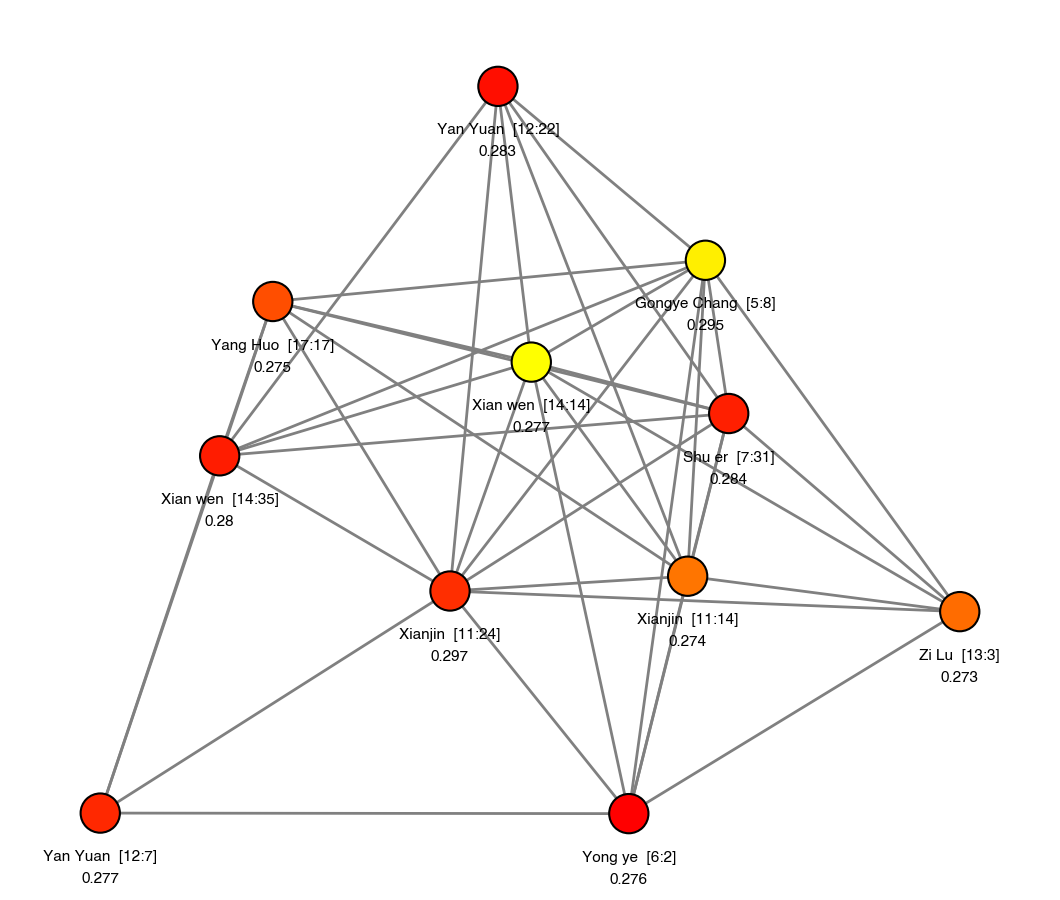

In [91]:
plot_centrality_based_subgraph(text, closeness_centrality_subgraph, nodes_data,nodes_to_include, centrality)


In [93]:
nodes_data

{404: 'Xianjin 先進 [11:24]',
 126: 'Gongye Chang 公冶長 [5:8]',
 247: 'Shu er 述而 [7:31]',
 461: 'Yan Yuan 顏淵 [12:22]',
 564: 'Xian wen 憲問 [14:35]',
 430: 'Yan Yuan 顏淵 [12:7]',
 539: 'Xian wen 憲問 [14:14]',
 164: 'Yong ye 雍也 [6:2]',
 689: 'Yang Huo 陽貨 [17:17]',
 368: 'Xianjin 先進 [11:14]',
 475: 'Zi Lu 子路 [13:3]'}

In [10]:
# CONVERT TO JPG


from PIL import Image
import matplotlib.pyplot as plt

texts =  ['Bible', 'Quran', 'Torah', 'Gita', 'Analects']
for text in texts:
    # Convert the image to RGB
    img = Image.open('data/analytics_data/all-MiniLM-L6-v2/05_threshold/'+ text+ '_degree_centrality_subgraph.png') 
    # Convert the image to RGB
    rgb_img = img.convert('RGB')
    rgb_img.save(text+ '_degree_centrality_subgraph.jpg','JPEG') 

In [102]:
high_centrality_references = list(nodes_data.values())

In [ ]:
from src.network_plots import get_verses_and_sources_from_references 

In [124]:
get_verses_and_sources_from_references(target_verses, high_centrality_references)

(['Xianjin 先進 [11:24]',
  'Gongye Chang 公冶長 [5:8]',
  'Shu er 述而 [7:31]',
  'Yan Yuan 顏淵 [12:22]',
  'Xian wen 憲問 [14:35]',
  'Yan Yuan 顏淵 [12:7]',
  'Xian wen 憲問 [14:14]',
  'Yong ye 雍也 [6:2]',
  'Yang Huo 陽貨 [17:17]',
  'Xianjin 先進 [11:14]',
  'Zi Lu 子路 [13:3]'],
 ['Analects',
  'Analects',
  'Analects',
  'Analects',
  'Analects',
  'Analects',
  'Analects',
  'Analects',
  'Analects',
  'Analects',
  'Analects'])

In [120]:
high_centrality_verses

['Xianjin 先進 [11:24]',
 'Gongye Chang 公冶長 [5:8]',
 'Shu er 述而 [7:31]',
 'Yan Yuan 顏淵 [12:22]',
 'Xian wen 憲問 [14:35]',
 'Yan Yuan 顏淵 [12:7]',
 'Xian wen 憲問 [14:14]',
 'Yong ye 雍也 [6:2]',
 'Yang Huo 陽貨 [17:17]',
 'Xianjin 先進 [11:14]',
 'Zi Lu 子路 [13:3]']